# Project Sales revenue forecast

# Task

* Build a model to predict sales revenue based on ad impressions (or expenditure) and other factors

* Evaluate the contribution of each advertising channel to sales revenue. The contribution of the advertising channel is calculated by comparing the original sales revenue and the forecasted sales revenue (after removing the advertising channel).

* Calculate total ROAS and weekly ROAS (return on advertising investment) and iROAS (return on incremental investment, based on current spending. For example, I spent 1000 on online video, how much profit will each next 1 spent?). Calculate iROAS by increasing current ad spend by 1%)

# Data description

The dataset contains data for 4 years (209 weeks) - transactions, ad impressions and ad spend, grouped by week.

1. Advertising factors


    Ad impressions (columns with “impressions_” prefix) - ad impressions in 13 different channels:
    direct mail, inserts, newspaper, digital audio, radio,
    TV, online video, SMM, online banners, email, SMS,
    affiliate program, contextual advertising)

    Ad spend (columns prefixed with “costs_”)
    
2. Other factors

    Macroeconomic factors (columns with “macro_” prefix) - business activity index, gasoline prices
    
    Discounts and markdowns (columns with “discount_” prefix)
    
    Number of offline stores (stores_count column)
    
    Sales revenue (column sales)
    
    Holidays (column “holiday”) - holidays in the specified week separated by a slash (/)

# Project plan

In this block, I will describe the next steps to solve the problem based on the article by google researchers "Bayesian Methods for Media Mix Modeling with Carryover and
Shape Effects"
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/46001.pdf

## Model

In this paper we propose media mix regression models that take into account both the carryover
and shape effects of advertising. As the model is no longer linear in the parameters, obtaining the
parameter estimates by maximizing the log likelihood or equivalently minimizing the residual sum
of squares is nontrivial. We use a Bayesian approach to estimate the model using Markov Chain
Monte Carlo (MCMC) algorithms. 

## Effects

In this case, we will be developing a model to understand how advertising spend affects sales.

According to the article "Media mix models (MMM) are used to understand how media spend affects sales and to optimize
the allocation of spend across media in order to get the optimal media mix"

This model takes into account :
* Carryover Effect (To model the carryover effect of advertising, we transform the time series of media spend in one channel through the adstock function), где AdStock - cumulative impact of advertising on consumer behavior.

* Shape Effect (To model the shape effect of advertising, the media spend needs to be transformed through a curvature function. A candidate for such a curvature function is the Hill function.)

## Description of the model

Let Φ denote the vector of parameters in the model in, X denote all the media variables,
Z denote all the control variables, and y denote the vector of response values. The frequentist
approach finds the most likely value of the parameters by maximizing the likelihood (MLE), as in where L(y|X, Φ) is the log likelihood given the data and the parameters.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "pic1.PNG")

## Plan

1. Create a regression model

2. Divide sales into contributions from each channel

3. Calculate ROAS and MROAS

# Import libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pystan
import os
import seaborn as sns

In [5]:
pd.options.display.float_format ='{:,.3f}'.format

# Import data

In [6]:
df = pd.read_csv('datasets/data.csv',delimiter = ';')

In [7]:
seas = pd.read_csv('datasets/seas.csv') # seasonality data

In [8]:
seas_cols = [col for col in seas.columns if 'seas_' in col]

In [9]:
df = pd.concat([df,seas[seas_cols]],axis = 1)

In [10]:
df.head(10)

,week_start,impressions_dm,impressions_inst,impressions_nsp,impressions_auddig,impressions_audtr,impressions_vidtr,impressions_viddig,impressions_so,impressions_on,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,03.08.2014,4863885,29087520,2421933,692315,37778097,10038746,2111112,0,3271007,...,0,0,0,0,0,0,0,0,0,0
1,10.08.2014,20887502,8345120,3984494,475810,12063657,9847977,587184,0,4260715,...,0,0,0,0,0,0,0,0,0,0
2,17.08.2014,11097724,17276800,1846832,784732,5770115,7235336,1015658,0,4405992,...,0,0,0,0,0,0,0,0,0,0
3,24.08.2014,1023446,18468480,2394834,1032301,12174000,8625122,2149160,0,6638320,...,0,0,0,0,0,0,0,0,0,0
4,31.08.2014,21109811,26659920,3312008,400456,31656134,19785657,2408661,0,4347752,...,0,0,0,0,0,0,0,0,0,0
5,07.09.2014,5965633,6255666,3215276,461272,12367053,5628842,1526423,0,3946028,...,0,0,0,0,0,0,0,0,0,0
6,14.09.2014,10034343,4232000,1365872,497614,9137332,5154671,1578405,0,5218305,...,0,0,0,0,0,0,0,0,0,0
7,21.09.2014,12764686,15474013,2024228,270547,20203293,7141152,1562746,0,8085311,...,0,0,0,0,0,0,0,0,0,0
8,28.09.2014,11745748,7490000,1715439,294330,1702373,6602727,1072990,0,4540636,...,0,0,0,0,0,0,0,0,0,0
9,05.10.2014,1745214,22230560,1840733,849692,15310836,10303035,582878,0,2477379,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df.describe()

,impressions_dm,impressions_inst,impressions_nsp,impressions_auddig,impressions_audtr,impressions_vidtr,impressions_viddig,impressions_so,impressions_on,impressions_em,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
count,209.000,209.000,209.000,209.000,209.000,209.000,209.000,209.000,209.000,209.000,...,209.000,209.000,209.000,209.000,209.000,209.000,209.000,209.000,209.000,209.000
mean,"9,544,510.005","12,477,171.799","1,616,957.062","1,002,816.440","22,951,032.325","9,846,006.622","1,096,359.565","13,820,284.995","4,742,088.608","3,585,527.593",...,0.081,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019,0.019
std,"8,293,082.220","10,249,589.560","2,203,341.460","812,284.835","15,671,236.593","9,254,274.058","1,247,631.130","10,917,668.078","2,669,164.999","1,467,660.345",...,0.274,0.137,0.137,0.137,0.137,0.137,0.137,0.137,0.137,0.137
min,0.000,"48,533.000",0.000,"15,618.000",0.000,0.000,0.000,0.000,"502,823.000","1,446,695.000",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,"2,087,021.000","5,304,240.000","254,234.000","457,722.000","12,367,053.000","4,378,348.000","393,170.000","4,305,911.000","2,893,497.000","2,416,255.000",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,"7,664,954.000","8,911,466.000","887,072.000","806,117.000","19,101,601.000","7,562,079.000","835,748.000","13,810,694.000","4,100,627.000","3,452,070.000",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,"15,338,517.000","17,869,200.000","2,248,483.000","1,344,765.000","29,560,035.000","11,391,924.000","1,298,726.000","19,743,057.000","6,108,048.000","4,431,058.000",...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,"39,798,714.000","65,451,456.000","15,531,812.000","5,418,819.000","90,665,385.000","65,829,561.000","10,788,194.000","58,821,663.000","13,944,271.000","8,614,296.000",...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [12]:
df[pd.get_dummies(df.holiday, prefix='holiday',drop_first = True).columns] =\
pd.get_dummies(df.holiday, prefix='holiday',drop_first = True)

In [13]:
df = df.drop(columns = 'holiday')

In [14]:
df = df[~df.index.isin(df[df['macro_gas_dpg'].str.contains('Feb')].index)]
df = df[~df.index.isin(df[df['costs_auddig'].str.contains('Jan')].index)]

In [15]:
week_start = df['week_start']

df = df.drop(columns = 'week_start').astype(float)

df['week_start'] = week_start

# Data preprocessing

## Creating lists with column names

* Advertising factors

Ad impressions

In [16]:
imp_cols=[col for col in df.columns if 'impressions_' in col]

Ad expenditure

In [17]:
costs_cols=[col for col in df.columns if 'costs_' in col]

* Macroeconomic factors

In [18]:
macro_cols = [col for col in df.columns if 'macro_' in col]

Discounts and markdowns

In [19]:
dis_cols = [col for col in df.columns if 'discount_' in col]

Number of offline shops

In [20]:
stores_cols = [col for col in df.columns if 'stores_count' in col]

Sales revenue

In [21]:
sales = [col for col in df.columns if 'sales' in col]

Holidays

In [22]:
holiday = [col for col in df.columns if 'holiday_' in col]

Seasonality

In [23]:
seas_cols = [col for col in seas.columns if 'seas_' in col]

Base_vars

In [24]:
base_vars = macro_cols+dis_cols+stores_cols+holiday+seas_cols

# Data Exploration

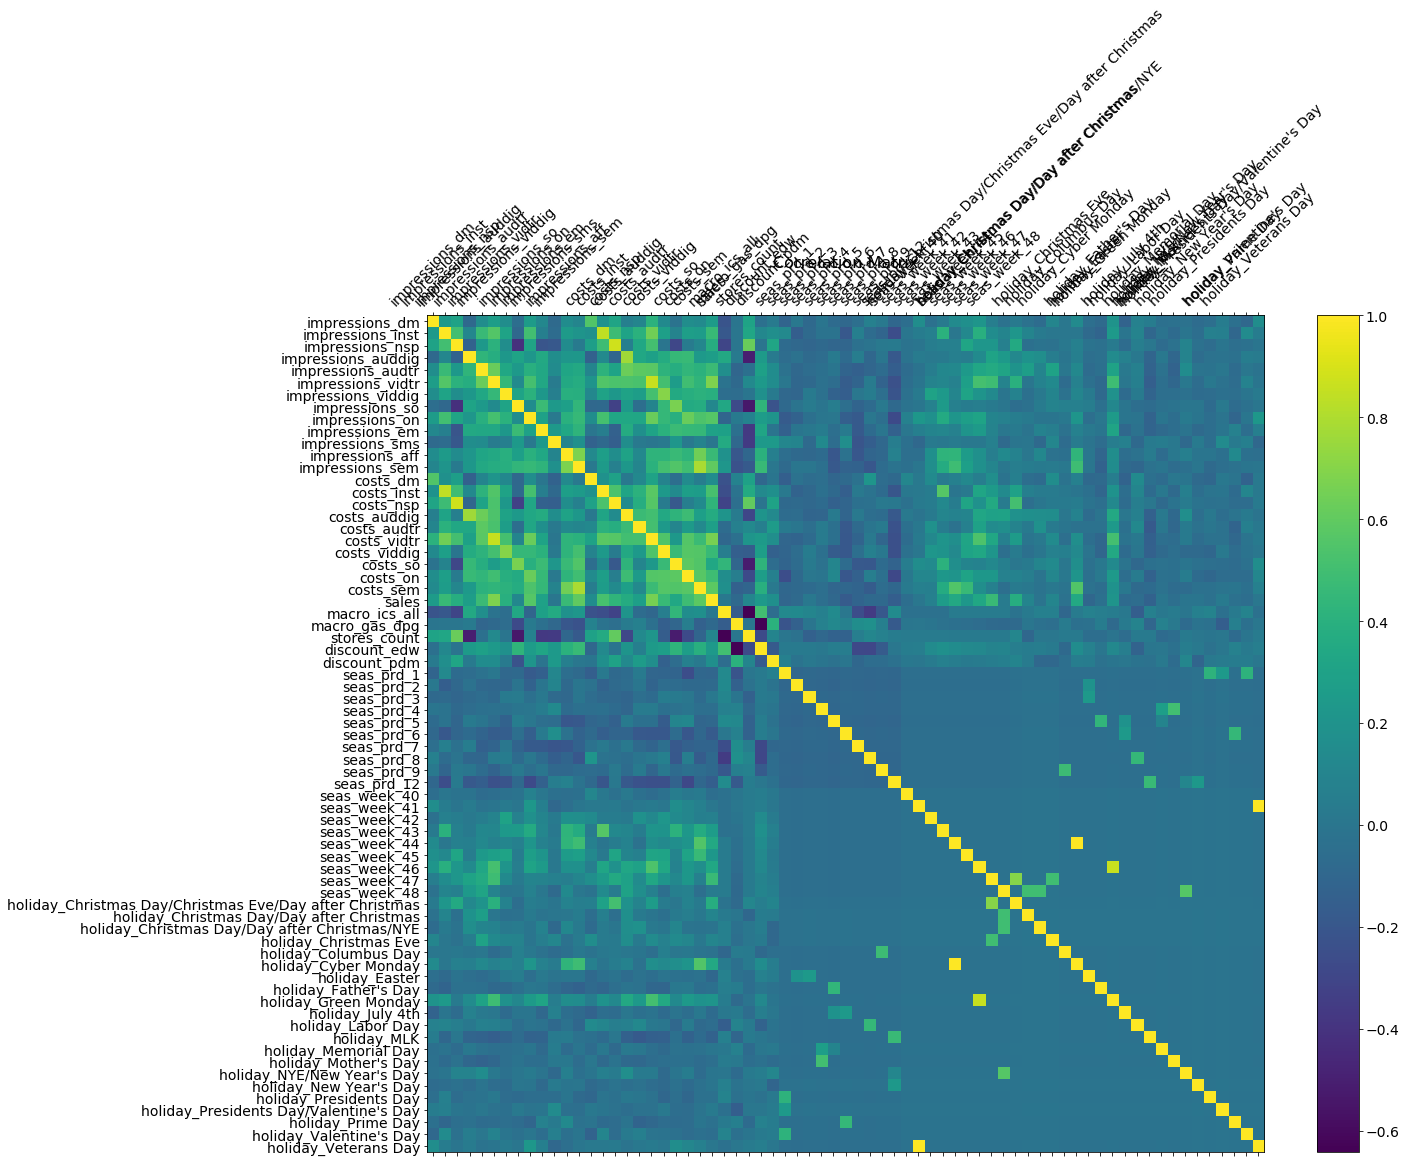

In [25]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Ad expenditures are slightly correlated with each other, and sometimes highly correlated with ad impressions.

# Create new features

## Adstock

The impact of the media on sales may lag behind the initial impact and last for several weeks. The carryover effect is modeled by Adstock:

In [26]:
Image(url= "pic2.PNG")

Function adstock

In [27]:
def apply_adstock(x, L, P, D):
    '''
    params:
    x: original media variable, array
    L: media effect duration
    P: media effect peak/lag, how many weeks behind the first exposure
    D: media channel decay/retention rate, effect concentration
    returns:
    array, adstocked media variable
    '''
    # List with variables trimmed for duration
    x = np.append(np.zeros(L-1), x)
    
    # Weights for each day of action
    weights = np.zeros(L)
    
    # Enumeration of all days in the total number
    for l in range(L):
        
        # wights
        weight = D**((l-P)**2)
        weights[L-1-l] = weight
    
    # Create a list with new values
    adstocked_x = []
    
    # Create updated values with the formula above
    for i in range(L-1, len(x)):
        x_array = x[i-L+1:i+1]
        xi = sum(x_array * weights)/sum(weights)
        
        # Adding the updated weight to the new list
        adstocked_x.append(xi)
    adstocked_x = np.array(adstocked_x)
    return adstocked_x

### Plot adstock with varying decay

Text(0.5,1,'Adstock Parameter: Decay')

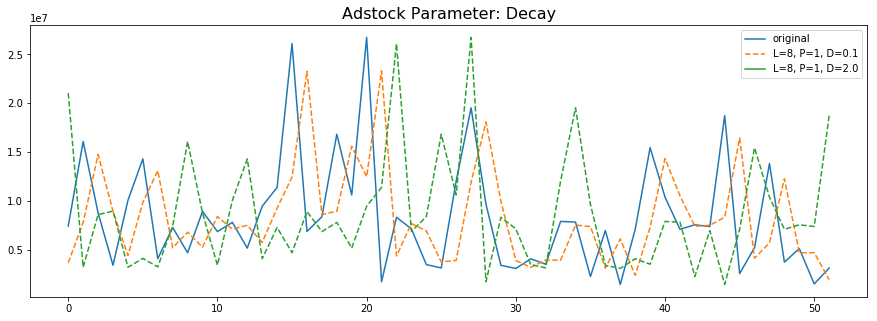

In [28]:
# plot adstock with varying decay
fig, ax = plt.subplots(figsize=(15,5))

psets = [
    [8, 1, 0.1],
    [8, 1, 2]]

# Vector with original impression values
xm = df[imp_cols[1]].values
sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')

# Loop with iteration of parameters
for i in range(len(psets)):
    
    # Duration
    p = psets[i]
    
    # Other parameters
    L, P, D = p[0], p[1], p[2]
    
    # Vector using the function written above
    xm_adstocked = apply_adstock(xm, L, P, D)
    
    # Plot
    sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax, 
                 label='L=%d, P=%d, D=%.1f'%(L, P, D))
    
    ax.lines[i+1].set_linestyle("--")
    
ax.set_title('Adstock Parameter: Decay', fontsize=16)


On the current graph we can see the work of the adstock effect when the decay parameter is changed (decay rate)

### Plot adstock with varying length

Text(0.5,1,'Adstock Parameter: Length')

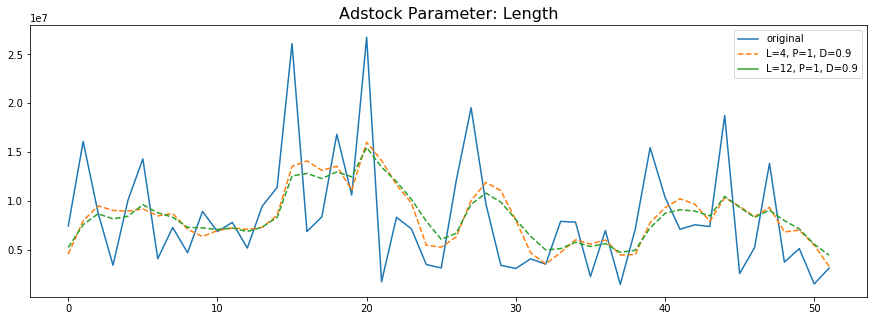

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
psets = [     [4, 1, 0.9],     [12, 1, 0.9] ]
xm = df[imp_cols[1]].values
sns.lineplot(x=range(52), y=xm[-52:], ax=ax, label='original')
for i in range(len(psets)):
    p = psets[i]
    L, P, D = p[0], p[1], p[2]
    xm_adstocked = apply_adstock(xm, L, P, D)
    sns.lineplot(x=range(52), y=xm_adstocked[-52:], ax=ax, 
                 label='L=%d, P=%d, D=%.1f'%(L, P, D))
    ax.lines[i+1].set_linestyle("--")
ax.set_title('Adstock Parameter: Length', fontsize=16)

### Function to create a table with adstock

In [30]:
def adstock_transform(df, md_cols, adstock_params):
    '''
    params:
    df: original data
    md_cols: list, media variables to be transformed
    adstock_params: dict, 
        e.g., {'sem': {'L': 8, 'P': 0, 'D': 0.1}, 'dm': {'L': 4, 'P': 1, 'D': 0.7}}
    returns: 
    adstocked df
    '''
    md_df = pd.DataFrame()
    for md_col in md_cols:
        md = md_col.split('_')[-1]
        L, P, D = adstock_params[md]['L'], adstock_params[md]['P'], adstock_params[md]['D']
        xa = apply_adstock(df[md_col].values, L, P, D)
        md_df[md_col] = xa
    return md_df

## Hill function

After a certain saturation point, the increase in spending will lead to a decrease in marginal profit, the channel will lose efficiency as you continue to overspend it. Diminishing returns are modeled by the Hill function

In [31]:
Image(url= "pic3.PNG")

K: half-saturation point

S: slope

In [32]:
def hill_transform(x, K, slope):
    return 1 / (1 + (x / K)**(-slope))

### Plot hill function with varying K and S

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  


Text(0.5,1,'Hill Function')

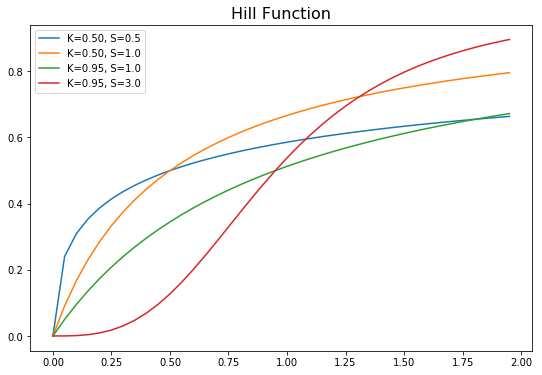

In [33]:
fig, ax = plt.subplots(figsize=(9,6))
psets = [
    [0.5, 0.5],
    [0.5, 1.0],
    [0.95, 1.0],
    [0.95, 3.0]
]
xm = np.arange(0,2,0.05)
for i in range(len(psets)):
    p = psets[i]
    K, slope = p[0], p[1]
    sns.lineplot(x=xm, y=hill_transform(xm, K, slope), ax=ax, 
                 label='K=%.2f, S=%.1f'%(K, slope))
    #ax.lines[i+1].set_linestyle("--")
ax.set_title('Hill Function', fontsize=16)

# Model

## Architecture

The model is built in a stacked way. Three models are trained:
- Control Model
- Marketing Mix Model
- Diminishing Return Model

In [34]:
Image(url= "pic4.png")

## Control model

Our goal in creating this model is to predict underlying sales as an input to MMM, this represents the underlying sales trend without any marketing activity.

In [35]:
Image(url= "pic5.png")

X1: Control variables positively associated with sales, including macroeconomics, number of stores, markdowns, vacations.

X2: control variables that can have a positive or negative effect on sales: seasonality.

Target variable: ln (sales).

Variables are centralized by mean.

### Additional functions

Distribution Creation Functions

In [36]:
from sklearn.metrics import mean_squared_error
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [37]:
def apply_mean_center(x):
    mu = np.mean(x)
    xm = x/mu
    return xm, mu

In [38]:
def mean_center_trandform(df, cols):
    '''
    returns: 
    mean-centered df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        df_new[col], mu = apply_mean_center(x)
        sc[col] = mu
    return df_new, sc

In [39]:
def mean_log1p_trandform(df, cols):
    '''
    returns: 
    mean-centered, log1p transformed df
    scaler, dict
    '''
    df_new = pd.DataFrame()
    sc = {}
    for col in cols:
        x = df[col].values
        xm, mu = apply_mean_center(x)
        sc[col] = mu
        df_new[col] = np.log1p(xm)
    return df_new, sc

In [40]:
import json
def save_json(data, file_name):
    with open(file_name, 'w') as fp:
        json.dump(data, fp)

def load_json(file_name):
    with open(file_name, 'r') as fp:
        data = json.load(fp)
    return data

In [41]:
df_ctrl, sc_ctrl = mean_center_trandform(df, sales+macro_cols+dis_cols+stores_cols)

In [42]:
df_ctrl = df_ctrl.merge(df[holiday+seas_cols],how = 'left',on = df.index)

In [43]:
# variables positively related to sales: macro economy, store count, markdown, holiday
pos_vars = [col for col in base_vars if col not in seas_cols]

#df_ctrl = df_ctrl.loc[:,~df_ctrl.columns.duplicated()].dropna()

X1 = df_ctrl[pos_vars].values

In [44]:
# variables may have either positive or negtive impact on sales: seasonality
pn_vars = seas_cols
X2 = df_ctrl[pn_vars].values

Setting a Variable for a Script

In [45]:
ctrl_data = {
    'N': len(df_ctrl),
    'K1': len(pos_vars), 
    'K2': len(pn_vars), 
    'X1': X1,
    'X2': X2, 
    'y': df_ctrl['sales'].values,
    'max_intercept': min(df_ctrl['sales'])
}

Script on stan

In [46]:
ctrl_code1 = '''
data {
  int N; // number of observations
  int K1; // number of positive predictors
  int K2; // number of positive/negative predictors
  real max_intercept; // restrict the intercept to be less than the minimum y
  matrix[N, K1] X1;
  matrix[N, K2] X2;
  vector[N] y; 
}

parameters {
  vector<lower=0>[K1] beta1; // regression coefficients for X1 (positive)
  vector[K2] beta2; // regression coefficients for X2
  real<lower=0, upper=max_intercept> alpha; // intercept
  real<lower=0> noise_var; // residual variance
}

model {
  // Define the priors
  beta1 ~ normal(0, 1); 
  beta2 ~ normal(0, 1); 
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  // The likelihood
  y ~ normal(X1*beta1 + X2*beta2 + alpha, sqrt(noise_var));
}
'''

Model's creation and training

In [47]:
sm1 = pystan.StanModel(model_code=ctrl_code1, verbose=True)
fit1 = sm1.sampling(data=ctrl_data, iter=2000, chains=4)
fit1_result = fit1.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_548939bc33801f8115bc26206558c913 NOW.
INFO:pystan:OS: linux, Python: 3.6.6 | packaged by conda-forge | (default, Oct 12 2018, 14:08:43) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.28.5


Compiling /tmp/pystan_d16yq5j3/stanfit4anon_model_548939bc33801f8115bc26206558c913_5364378262205628421.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_d16yq5j3/stanfit4anon_model_548939bc33801f8115bc26206558c913_5364378262205628421.pyx
building 'stanfit4anon_model_548939bc33801f8115bc26206558c913_5364378262205628421' extension
creating /tmp/pystan_d16yq5j3/tmp
creating /tmp/pystan_d16yq5j3/tmp/pystan_d16yq5j3
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -m64 -fPIC -m64 -fPIC -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_d16yq5j3 -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0 -I/opt/conda/lib/python3.6/site-packages/pys

Model's evaluation

In [48]:
def extract_ctrl_model(fit_result, pos_vars=pos_vars, pn_vars=pn_vars, 
                       extract_param_list=False):
    ctrl_model = {}
    ctrl_model['pos_vars'] = pos_vars
    ctrl_model['pn_vars'] = pn_vars
    ctrl_model['beta1'] = fit_result['beta1'].mean(axis=0).tolist()
    ctrl_model['beta2'] = fit_result['beta2'].mean(axis=0).tolist()
    ctrl_model['alpha'] = fit_result['alpha'].mean()
    if extract_param_list:
        ctrl_model['beta1_list'] = fit_result['beta1'].tolist()
        ctrl_model['beta2_list'] = fit_result['beta2'].tolist()
        ctrl_model['alpha_list'] = fit_result['alpha'].tolist()
    return ctrl_model

In [49]:
def ctrl_model_predict(ctrl_model, df):
    pos_vars, pn_vars = ctrl_model['pos_vars'], ctrl_model['pn_vars'] 
    X1, X2 = df[pos_vars], df[pn_vars]
    beta1, beta2 = np.array(ctrl_model['beta1']), np.array(ctrl_model['beta2'])
    alpha = ctrl_model['alpha']
    y_pred = np.dot(X1, beta1) + np.dot(X2, beta2) + alpha
    return y_pred

In [50]:
base_sales_model = extract_ctrl_model(fit1_result, pos_vars=pos_vars, pn_vars=pn_vars)
base_sales = ctrl_model_predict(base_sales_model, df_ctrl)
df['base_sales'] = base_sales*sc_ctrl['sales']
# evaluate control model
print('mape: ', mean_absolute_percentage_error(df['sales'], df['base_sales']))

mape:  25.5954685137


## Marketing Mix Model

* In the current model, we need to find suitable advertising parameters for media channels

* Divide sales by media channel contribution

In [51]:
Image(url= "pic6.png")

L: duration of media exposure

P: peak media exposure

D: reducing media exposure

X: Ad Display Variables and Base Sales

Target variable: ln (sales)

In [52]:
df_mmm, sc_mmm = mean_log1p_trandform(df, ['sales', 'base_sales'])
mu_mdip = df[imp_cols].apply(np.mean, axis=0).values
max_lag = 8
num_media = len(imp_cols)
# padding zero * (max_lag-1) rows
X_media = np.concatenate((np.zeros((max_lag-1, num_media)), df[imp_cols].values), axis=0)
X_ctrl = df_mmm['base_sales'].values.reshape(len(df),1)

In [53]:
model_data2 = {
    'N': len(df),
    'max_lag': max_lag, 
    'num_media': num_media,
    'X_media': X_media, 
    'mu_mdip': mu_mdip,
    'num_ctrl': X_ctrl.shape[1],
    'X_ctrl': X_ctrl, 
    'y': df_mmm['sales'].values
}

In [54]:
model_code2 = '''
functions {
  // the adstock transformation with a vector of weights
  real Adstock(vector t, row_vector weights) {
    return dot_product(t, weights) / sum(weights);
  }
}
data {
  // the total number of observations
  int<lower=1> N;
  // the vector of sales
  real y[N];
  // the maximum duration of lag effect, in weeks
  int<lower=1> max_lag;
  // the number of media channels
  int<lower=1> num_media;
  // matrix of media variables
  matrix[N+max_lag-1, num_media] X_media;
  // vector of media variables' mean
  real mu_mdip[num_media];
  // the number of other control variables
  int<lower=1> num_ctrl;
  // a matrix of control variables
  matrix[N, num_ctrl] X_ctrl;
}
parameters {
  // residual variance
  real<lower=0> noise_var;
  // the intercept
  real tau;
  // the coefficients for media variables and base sales
  vector<lower=0>[num_media+num_ctrl] beta;
  // the decay and peak parameter for the adstock transformation of
  // each media
  vector<lower=0,upper=1>[num_media] decay;
  vector<lower=0,upper=ceil(max_lag/2)>[num_media] peak;
}
transformed parameters {
  // the cumulative media effect after adstock
  real cum_effect;
  // matrix of media variables after adstock
  matrix[N, num_media] X_media_adstocked;
  // matrix of all predictors
  matrix[N, num_media+num_ctrl] X;
  
  // adstock, mean-center, log1p transformation
  row_vector[max_lag] lag_weights;
  for (nn in 1:N) {
    for (media in 1 : num_media) {
      for (lag in 1 : max_lag) {
        lag_weights[max_lag-lag+1] <- pow(decay[media], (lag - 1 - peak[media]) ^ 2);
      }
     cum_effect <- Adstock(sub_col(X_media, nn, media, max_lag), lag_weights);
     X_media_adstocked[nn, media] <- log1p(cum_effect/mu_mdip[media]);
    }
  X <- append_col(X_media_adstocked, X_ctrl);
  } 
}
model {
  decay ~ beta(3,3);
  peak ~ uniform(0, ceil(max_lag/2));
  tau ~ normal(0, 5);
  for (i in 1 : num_media+num_ctrl) {
    beta[i] ~ normal(0, 1);
  }
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
  y ~ normal(tau + X * beta, sqrt(noise_var));
}
'''

In [55]:
sm2 = pystan.StanModel(model_code=model_code2, verbose=True)
fit2 = sm2.sampling(data=model_data2, iter=1000, chains=3)
fit2_result = fit2.extract()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c6677ffefdee0513f144508ee1783d0c NOW.
INFO:pystan:OS: linux, Python: 3.6.6 | packaged by conda-forge | (default, Oct 12 2018, 14:08:43) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.28.5


Compiling /tmp/pystan_nhqgay15/stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_5228675638359260602.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_nhqgay15/stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_5228675638359260602.pyx
building 'stanfit4anon_model_c6677ffefdee0513f144508ee1783d0c_5228675638359260602' extension
creating /tmp/pystan_nhqgay15/tmp
creating /tmp/pystan_nhqgay15/tmp/pystan_nhqgay15
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -m64 -fPIC -m64 -fPIC -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_nhqgay15 -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0 -I/opt/conda/lib/python3.6/site-packages/pys

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [56]:
def extract_mmm(fit_result, max_lag=max_lag, 
                media_vars=imp_cols, ctrl_vars=['base_sales'], 
                extract_param_list=True):
    mmm = {}
    
    mmm['max_lag'] = max_lag
    mmm['media_vars'], mmm['ctrl_vars'] = media_vars, ctrl_vars
    mmm['decay'] = decay = fit_result['decay'].mean(axis=0).tolist()
    mmm['peak'] = peak = fit_result['peak'].mean(axis=0).tolist()
    mmm['beta'] = fit_result['beta'].mean(axis=0).tolist()
    mmm['tau'] = fit_result['tau'].mean()
    if extract_param_list:
        mmm['decay_list'] = fit_result['decay'].tolist()
        mmm['peak_list'] = fit_result['peak'].tolist()
        mmm['beta_list'] = fit_result['beta'].tolist()
        mmm['tau_list'] = fit_result['tau'].tolist()
    
    adstock_params = {}
    media_names = [col.replace('impressions_', '') for col in media_vars]
    for i in range(len(media_names)):
        adstock_params[media_names[i]] = {
            'L': max_lag,
            'P': peak[i],
            'D': decay[i]
        }
    mmm['adstock_params'] = adstock_params
    return mmm

In [57]:
mmm = extract_mmm(fit2, max_lag=max_lag, 
                media_vars=imp_cols, ctrl_vars=['base_sales'])

### Distribution of media coefficients

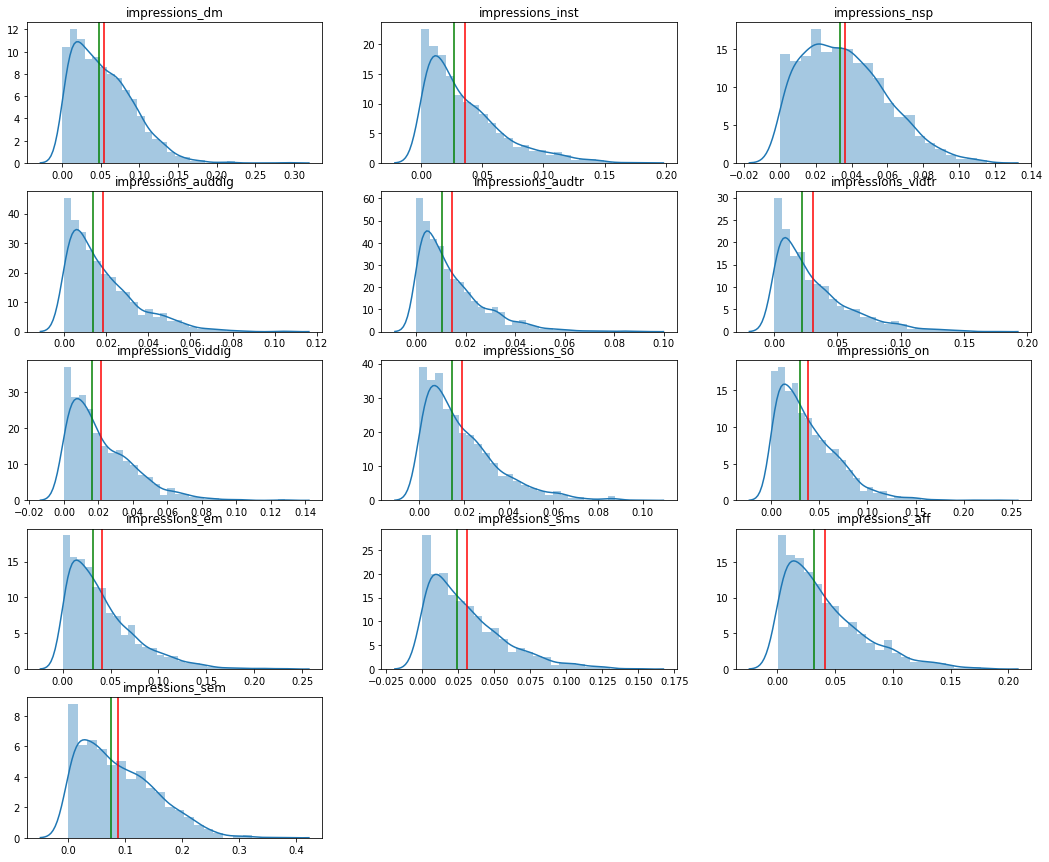

In [58]:
beta_media = {}
for i in range(len(mmm['media_vars'])):
    md = mmm['media_vars'][i]
    betas = []
    for j in range(len(mmm['beta_list'])):
        betas.append(mmm['beta_list'][j][i])
    beta_media[md] = np.array(betas)

f = plt.figure(figsize=(18,15))
for i in range(len(mmm['media_vars'])):
    ax = f.add_subplot(5,3,i+1)
    md = mmm['media_vars'][i]
    x = beta_media[md]
    mean_x = x.mean()
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-')
    ax.axvline(median_x, color='g', linestyle='-')
    ax.set_title(md)

## Diminishing Return Model

Goal: For each channel, find the relationship (using Hill's function) between spend and contribution so that ROAS and marginal ROAS can be calculated.

In [59]:
def mmm_decompose_contrib(mmm, df, original_sales=df['sales']):
    # adstock params
    adstock_params = mmm['adstock_params']
    # coefficients, intercept
    beta, tau = mmm['beta'], mmm['tau']
    # variables
    media_vars, ctrl_vars = mmm['media_vars'], mmm['ctrl_vars']
    num_media, num_ctrl = len(media_vars), len(ctrl_vars)
    # X_media2: adstocked, mean-centered media variables + 1
    X_media2 = adstock_transform(df, media_vars, adstock_params)
    X_media2, sc_mmm2 = mean_center_trandform(X_media2, media_vars)
    X_media2 = X_media2 + 1
    # X_ctrl2, mean-centered control variables + 1
    X_ctrl2, sc_mmm2_1 = mean_center_trandform(df[ctrl_vars], ctrl_vars)
    X_ctrl2 = X_ctrl2 + 1
    # y_true2, mean-centered sales variable + 1
    y_true2, sc_mmm2_2 = mean_center_trandform(df, ['sales'])
    y_true2 = y_true2 + 1
    sc_mmm2.update(sc_mmm2_1)
    sc_mmm2.update(sc_mmm2_2)
    # X2 <- media variables + ctrl variable
    X2 = pd.concat([X_media2, X_ctrl2], axis=1)

    # 1. compute each media/control factor: 
    # log-log model: log(sales) = log(X[0])*beta[0] + ... + log(X[13])*beta[13] + tau
    # multiplicative model: sales = X[0]^beta[0] * ... * X[13]^beta[13] * e^tau
    # each factor = X[i]^beta[i]
    # intercept = e^tau
    factor_df = pd.DataFrame(columns=media_vars+ctrl_vars+['intercept'])
    for i in range(num_media):
        colname = media_vars[i]
        factor_df[colname] = X2[colname] ** beta[i]
    for i in range(num_ctrl):
        colname = ctrl_vars[i]
        factor_df[colname] = X2[colname] ** beta[num_media+i]
    factor_df['intercept'] = np.exp(tau)

    # 2. calculate the product of all factors -> y_pred
    # baseline = intercept * control factor = e^tau * X[13]^beta[13]
    y_pred = factor_df.apply(np.prod, axis=1)
    factor_df['y_pred'], factor_df['y_true2'] = y_pred, y_true2
    factor_df['baseline'] = factor_df[['intercept']+ctrl_vars].apply(np.prod, axis=1)

    # 3. calculate each media factor's contribution
    # media contribution = total volume – volume upon removal of the media factor
    mc_df = pd.DataFrame(columns=media_vars+['baseline'])
    for col in media_vars:
        mc_df[col] = factor_df['y_true2'] - factor_df['y_true2']/factor_df[col]
    mc_df['baseline'] = factor_df['baseline']
    mc_df['y_true2'] = factor_df['y_true2']

    # 4. scale contribution
    # predicted total media contribution: product of all media factors
    mc_df['mc_pred'] = mc_df[media_vars].apply(np.sum, axis=1)
    # true total media contribution: total volume - baseline
    mc_df['mc_true'] = mc_df['y_true2'] - mc_df['baseline']
    # predicted total media contribution is slightly different from true total media contribution
    # scale each media factor’s contribution by removing the delta volume proportionally
    mc_df['mc_delta'] =  mc_df['mc_pred'] - mc_df['mc_true']
    for col in media_vars:
        mc_df[col] = mc_df[col] - mc_df['mc_delta']*mc_df[col]/mc_df['mc_pred']

    # 5. scale mc_df based on original sales
    mc_df['sales'] = original_sales
    for col in media_vars+['baseline']:
        mc_df[col] = mc_df[col]*mc_df['sales']/mc_df['y_true2']
    
    print('rmse (log-log model): ', 
         mean_squared_error(np.log(y_true2), np.log(y_pred)) ** (1/2))
    print('mape (multiplicative model): ', 
         mean_absolute_percentage_error(y_true2, y_pred))
    return mc_df

In [60]:
def calc_media_contrib_pct(mc_df, media_vars=imp_cols, sales_col='sales', period=52):
    '''
    returns:
    mc_pct: percentage over total sales
    mc_pct2: percentage over incremental sales (sales contributed by media channels)
    '''
    mc_pct = {}
    mc_pct2 = {}
    s = 0
    if period is None:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col]).mean()
    else:
        for col in (media_vars+['baseline']):
            mc_pct[col] = (mc_df[col]/mc_df[sales_col])[-period:].mean()
    for m in media_vars:
        s += mc_pct[m]
    for m in media_vars:
        mc_pct2[m] = mc_pct[m]/s
    return mc_pct, mc_pct2

In [61]:
mc_df = mmm_decompose_contrib(mmm, df, original_sales=df['sales'])
adstock_params = mmm['adstock_params']
mc_pct, mc_pct2 = calc_media_contrib_pct(mc_df, period=52)

rmse (log-log model):  0.135312283266
mape (multiplicative model):  20.669153095


In [62]:
def create_hill_model_data(df, mc_df, adstock_params, media):
    y = mc_df['impressions_'+media].fillna(mc_df['impressions_'+media].median()).values
    L, P, D = adstock_params[media]['L'], adstock_params[media]['P'], adstock_params[media]['D']
    x = df['costs_'+media].values
    x_adstocked = apply_adstock(x, L, P, D)
    # centralize
    mu_x, mu_y = x_adstocked.mean(), y.mean()
    sc = {'x': mu_x, 'y': mu_y}
    x = x_adstocked/mu_x
    y = y/mu_y
        
    model_data = {
        'N': len(y),
        'y': y,
        'X': x
    }
    return model_data, sc

In [63]:
model_code3 = '''
functions {
  // the Hill function
  real Hill(real t, real ec, real slope) {
  return 1 / (1 + (t / ec)^(-slope));
  }
}

data {
  // the total number of observations
  int<lower=1> N;
  // y: vector of media contribution
  vector[N] y;
  // X: vector of adstocked media spending
  vector[N] X;
}

parameters {
  // residual variance
  real<lower=0> noise_var;
  // regression coefficient
  real<lower=0> beta_hill;
  // ec50 and slope for Hill function of the media
  real<lower=0,upper=1> ec;
  real<lower=0> slope;
}

transformed parameters {
  // a vector of the mean response
  vector[N] mu;
  for (i in 1:N) {
    mu[i] <- beta_hill * Hill(X[i], ec, slope);
  }
}

model {
  slope ~ gamma(3, 1);
  ec ~ beta(2, 2);
  beta_hill ~ normal(0, 1);
  noise_var ~ inv_gamma(0.05, 0.05 * 0.01); 
  y ~ normal(mu, sqrt(noise_var));
}
'''

In [64]:
# pipeline for training one hill model for a media channel
def train_hill_model(df, mc_df, adstock_params, media, sm):
    '''
    params:
    df: original data
    mc_df: media contribution df derived from MMM
    adstock_params: adstock parameter dict output by MMM
    media: 'dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem'
    sm: stan model object    
    returns:
    a dict of model data, scaler, parameters
    '''
    data, sc = create_hill_model_data(df, mc_df, adstock_params, media)
    fit = sm.sampling(data=data, iter=2000, chains=4)
    fit_result = fit.extract()
    hill_model = {
        'beta_hill_list': fit_result['beta_hill'].tolist(),
        'ec_list': fit_result['ec'].tolist(),
        'slope_list': fit_result['slope'].tolist(),
        'sc': sc,
        'data': {
            'X': data['X'].tolist(),
            'y': data['y'].tolist(),
        }
    }
    return hill_model

In [65]:
# extract params by mean or median
# almost no difference, choose either one
def extract_hill_model_params(hill_model, method='mean'):
    if method=='mean':
        hill_model_params = {
            'beta_hill': np.mean(hill_model['beta_hill_list']), 
            'ec': np.mean(hill_model['ec_list']), 
            'slope': np.mean(hill_model['slope_list'])
        }
    elif method=='median':
        hill_model_params = {
            'beta_hill': np.median(hill_model['beta_hill_list']), 
            'ec': np.median(hill_model['ec_list']), 
            'slope': np.median(hill_model['slope_list'])
        }
    return hill_model_params

In [66]:
def hill_model_predict(hill_model_params, x):
    beta_hill, ec, slope = hill_model_params['beta_hill'], hill_model_params['ec'], hill_model_params['slope']
    y_pred = beta_hill * hill_transform(x, ec, slope)
    return y_pred

In [67]:
def evaluate_hill_model(hill_model, hill_model_params):
    x = np.array(hill_model['data']['X'])
    y_true = np.array(hill_model['data']['y']) * hill_model['sc']['y']
    y_pred = hill_model_predict(hill_model_params, x) * hill_model['sc']['y']
    print('mape on original data: ', 
         mean_absolute_percentage_error(y_true, y_pred))
    return y_true, y_pred

In [68]:
# train hill models for all media channels
sm3 = pystan.StanModel(model_code=model_code3, verbose=True)
hill_models = {}
to_train = ['dm', 'inst', 'nsp', 'auddig', 'audtr', 'vidtr', 'viddig', 'so', 'on', 'sem']
for media in to_train:
    print('training for media: ', media)
    hill_model = train_hill_model(df, mc_df, adstock_params, media, sm3)
    hill_models[media] = hill_model

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a4112ee77501d9c967031faa602df9b9 NOW.
INFO:pystan:OS: linux, Python: 3.6.6 | packaged by conda-forge | (default, Oct 12 2018, 14:08:43) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)], Cython 0.28.5


Compiling /tmp/pystan_f1kzuh5_/stanfit4anon_model_a4112ee77501d9c967031faa602df9b9_2913461157417807809.pyx because it changed.
[1/1] Cythonizing /tmp/pystan_f1kzuh5_/stanfit4anon_model_a4112ee77501d9c967031faa602df9b9_2913461157417807809.pyx
building 'stanfit4anon_model_a4112ee77501d9c967031faa602df9b9_2913461157417807809' extension
creating /tmp/pystan_f1kzuh5_/tmp
creating /tmp/pystan_f1kzuh5_/tmp/pystan_f1kzuh5_
gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -m64 -fPIC -m64 -fPIC -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/pystan_f1kzuh5_ -I/opt/conda/lib/python3.6/site-packages/pystan -I/opt/conda/lib/python3.6/site-packages/pystan/stan/src -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/eigen_3.3.3 -I/opt/conda/lib/python3.6/site-packages/pystan/stan/lib/stan_math/lib/boost_1.69.0 -I/opt/conda/lib/python3.6/site-packages/pys

training for media:  on
training for media:  sem


In [69]:
# extract params by mean
hill_model_params_mean, hill_model_params_med = {}, {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    params1 = extract_hill_model_params(hill_model, method='mean')
    params1['sc'] = hill_model['sc']
    hill_model_params_mean[md] = params1

In [70]:
# evaluate model params extracted by mean
for md in list(hill_models.keys()):
    print('evaluating media: ', md)
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    _ = evaluate_hill_model(hill_model, hill_model_params)

evaluating media:  dm
mape on original data:  79.9478642638
evaluating media:  inst
mape on original data:  81.422818047
evaluating media:  nsp
mape on original data:  87.213289398
evaluating media:  auddig
mape on original data:  80.9959391286
evaluating media:  audtr
mape on original data:  77.8280022426
evaluating media:  vidtr
mape on original data:  81.4809409977
evaluating media:  viddig
mape on original data:  93.6863674927
evaluating media:  so
mape on original data:  nan
evaluating media:  on
mape on original data:  81.4267444401
evaluating media:  sem
mape on original data:  73.0214644564


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


### Distribution of media coefficients

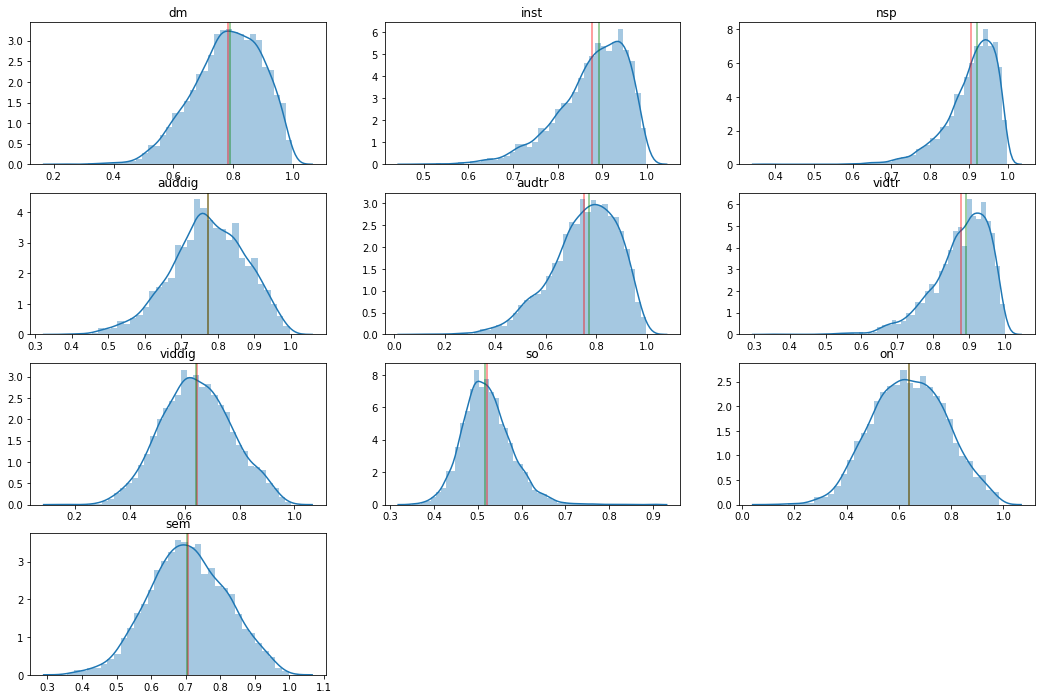

In [71]:
# plot ec distribution
f = plt.figure(figsize=(18,12))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    x = hill_models[md]['ec_list']
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set_title(md)

### Distribution of weekly ROI

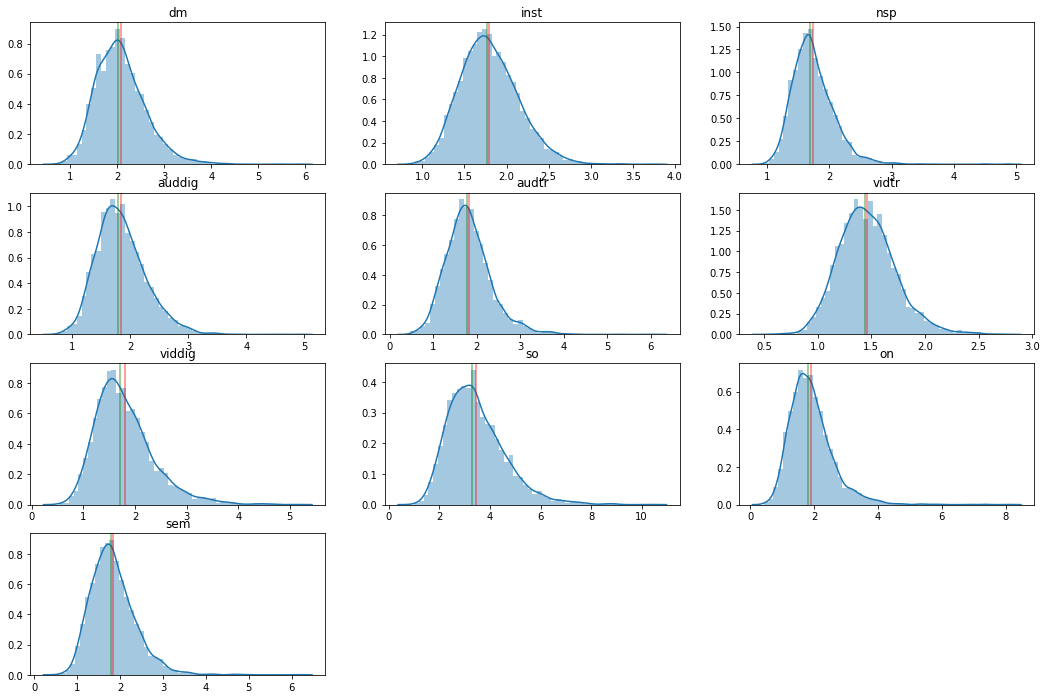

In [72]:
# plot slope distribution
f = plt.figure(figsize=(18,12))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    x = hill_models[md]['slope_list']
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set_title(md)

### Diminishing returns model

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


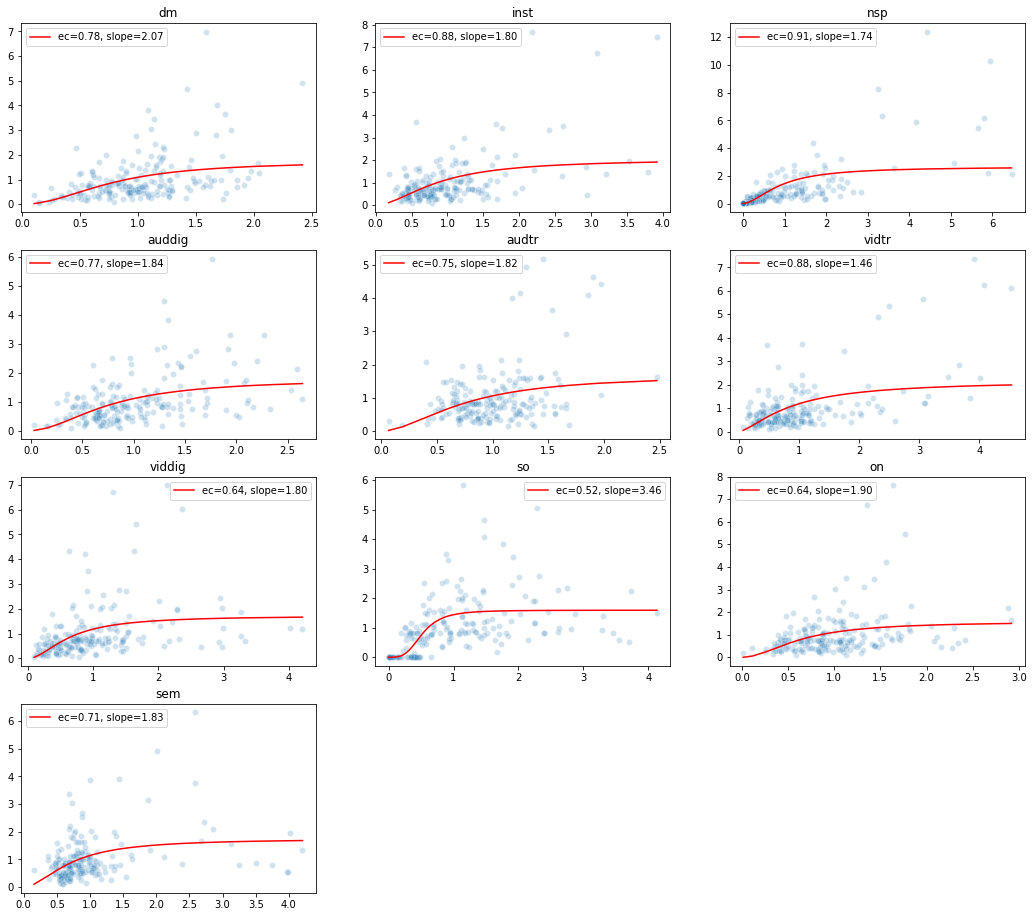

In [73]:
# plot fitted hill function
f = plt.figure(figsize=(18,16))
hm_keys = list(hill_models.keys())
for i in range(len(hm_keys)):
    ax = f.add_subplot(4,3,i+1)
    md = hm_keys[i]
    hm = hill_models[md]
    hmp = hill_model_params_mean[md]
    x, y = hm['data']['X'], hm['data']['y']
    #mu_x, mu_y = hm['sc']['x'], hm['sc']['y']
    ec, slope = hmp['ec'], hmp['slope']
    x_sorted = np.array(sorted(x))
    y_fit = hill_model_predict(hmp, x_sorted)
    ax = sns.scatterplot(x=x, y=y, alpha=0.2)
    ax = sns.lineplot(x=x_sorted, y=y_fit, color='r', 
                 label='ec=%.2f, slope=%.2f'%(ec, slope))
    ax.set_title(md)

In [74]:
# Calculate overall ROAS and weekly ROAS
# - Overall ROAS = total contribution / total spending
# - Weekly ROAS = weekly contribution / weekly spending

# adstocked media spending
ms_df = pd.DataFrame()
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    x = np.array(hill_model['data']['X']) * hill_model['sc']['x']
    ms_df['costs_'+md] = x
# ms_df.to_csv('ms_df1.csv', index=False)

In [75]:
# calc overall ROAS of a given period
def calc_roas(mc_df, ms_df, period=None):
    roas = {}
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for i in range(len(md_names)):
        md = md_names[i]
        sp, mc = ms_df['costs_'+md], mc_df['impressions_'+md]
        if period is None:
            md_roas = mc.sum()/sp.sum()
        else:
            md_roas = mc[-period:].sum()/sp[-period:].sum()
        roas[md] = md_roas
    return roas

In [76]:
# calc weekly ROAS
def calc_weekly_roas(mc_df, ms_df):
    weekly_roas = pd.DataFrame()
    md_names = [col.split('_')[-1] for col in ms_df.columns]
    for md in md_names:
        weekly_roas[md] = mc_df['impressions_'+md]/ms_df['costs_'+md]
    weekly_roas.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
    return weekly_roas

In [77]:
roas_1y = calc_roas(mc_df, ms_df, period=52)
weekly_roas = calc_weekly_roas(mc_df, ms_df)
roas1y_df = pd.DataFrame(index=weekly_roas.columns.tolist())
roas1y_df['roas_mean'] = weekly_roas[-52:].apply(np.mean, axis=0)
roas1y_df['roas_median'] = weekly_roas[-52:].apply(np.median, axis=0)

### Distribution of weekly ROI

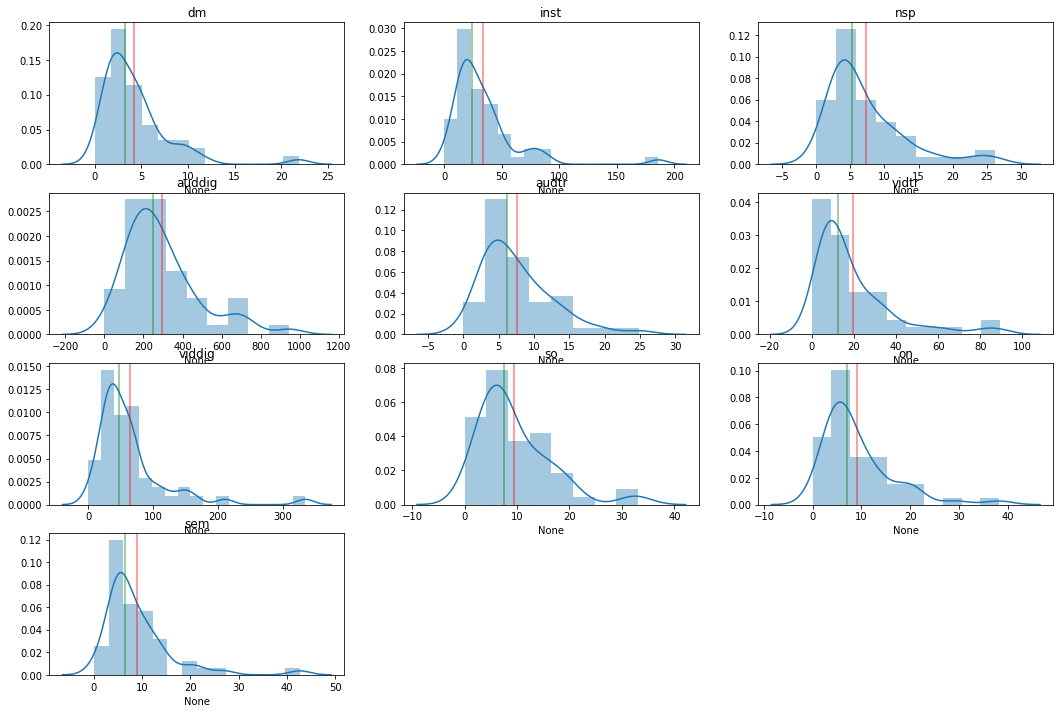

In [78]:
# plot weekly ROAS distribution of past 1 year
# median: green line, mean: red line
f = plt.figure(figsize=(18,12))
for i in range(len(weekly_roas.columns)):
    md = weekly_roas.columns[i]
    ax = f.add_subplot(4,3,i+1)
    x = weekly_roas[md][-52:]
    mean_x = np.mean(x)
    median_x = np.median(x)
    ax = sns.distplot(x)
    ax.axvline(mean_x, color='r', linestyle='-', alpha=0.5)
    ax.axvline(median_x, color='g', linestyle='-', alpha=0.5)
    ax.set(xlabel=None)
    ax.set_title(md)

In [79]:
def calc_mroas(hill_model, hill_model_params, period=52):
    '''
    calculate mROAS for a media
    params:
    hill_model: a dict containing model data and scaling factor
    hill_model_params: a dict containing beta_hill, ec, slope
    period: in weeks, the period used to calculate ROAS and mROAS. 52 is last one year.
    return:
    mROAS value
    '''
    mu_x, mu_y = hill_model['sc']['x'], hill_model['sc']['y']
    # get current media spending level over the period specified
    cur_sp = np.asarray(hill_model['data']['X'])
    if period is not None:
        cur_sp = cur_sp[-period:]
    cur_mc = sum(hill_model_predict(hill_model_params, cur_sp) * mu_y)
    # next spending level: increase by 1%
    next_sp = cur_sp * 1.01
    # media contribution under next spending level
    next_mc = sum(hill_model_predict(hill_model_params, next_sp) * mu_y)
    
    # mROAS
    delta_mc = next_mc - cur_mc
    delta_sp = sum(next_sp * mu_x) - sum(cur_sp * mu_x)
    mroas = delta_mc/delta_sp
    return mroas

In [80]:
# calc mROAS of recent 1 year
mroas_1y = {}
for md in list(hill_models.keys()):
    hill_model = hill_models[md]
    hill_model_params = hill_model_params_mean[md]
    mroas_1y[md] = calc_mroas(hill_model, hill_model_params, period=52)

In [81]:
roas1y_df = pd.concat([
    roas1y_df[['roas_mean', 'roas_median']],
    pd.DataFrame.from_dict(mroas_1y, orient='index', columns=['mroas']),
    pd.DataFrame.from_dict(roas_1y, orient='index', columns=['roas_avg'])
], axis=1)
# roas1y_df.to_csv('roas1y_df1.csv')

In [82]:
roas1y_df

,roas_mean,roas_median,mroas,roas_avg
dm,4.230,3.215,4.358,3.878
inst,33.819,24.162,32.581,30.079
nsp,7.299,5.243,11.683,7.944
auddig,293.049,250.162,124.229,271.141
audtr,7.565,6.148,4.969,7.092
vidtr,19.495,12.331,8.042,11.787
viddig,63.974,47.268,33.991,50.918
so,9.495,7.446,1.283,8.153
on,9.161,7.040,4.648,7.797
sem,8.903,6.494,5.112,7.303
